In [1]:
import torch
import torchaudio

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

/root/anaconda3/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [42]:
import numpy as np
np_rng = np.random.default_rng(1)
import pandas as pd


import urllib.parse
from IPython.display import display, Markdown

import os

from lidbox.meta import (
    common_voice,
    generate_label2target,
    verify_integrity,
    read_audio_durations,
    random_oversampling_on_split
)


train = pd.read_csv("/tf/datasets/train.tsv", sep="\t")
test = pd.read_csv("/tf/datasets/test.tsv", sep="\t")
dev = pd.read_csv("/tf/datasets/dev.tsv", sep="\t")

train["path"] = train["path"].apply(lambda x: x[:-3] + "mp3")
test["path"] = test["path"].apply(lambda x: x[:-3] + "mp3")
dev["path"] = dev["path"].apply(lambda x: x[:-3] + "mp3")

train["split"] = "train"
test["split"] = "test"
dev["split"] = "dev"
#test = test.sample(30000, replace=False)
meta = pd.concat([train, test, dev])


In [43]:
meta.loc[meta["locale"] != "kz", "path"] = "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/" +  meta.loc[meta["locale"] != "kz"]["locale"] + "/clips/" + meta.loc[meta["locale"] != "kz"]["path"]
targets = {"kz": 0, "ru": 1, "en":2, "other":3}
meta["target"] = meta["locale"]
meta.loc[(meta["locale"] != "kz") & (meta["locale"] != "ru") & (meta["locale"]!="en"), "target"] = "other"
meta = meta.loc[meta["path"] != "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/kz/clips/5f590a130a73c.mp3"]
meta = meta.loc[meta["path"] != "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/kz/clips/5ef9bd9ba7029.mp3"]

meta["id"] = meta["Unnamed: 0"].apply(str)
meta["target"] = meta["target"].map(targets)

meta

,Unnamed: 0,path,locale,split,target,id
0,1486,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,ru,train,1,1486
1,56701,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,kz,train,0,56701
2,3364,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,ru,train,1,3364
3,110475,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,rw,train,3,110475
4,45384,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,en,train,2,45384
...,...,...,...,...,...,...
30751,2677,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,ru,dev,1,2677
30752,881,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,ru,dev,1,881
30753,68709,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,kz,dev,0,68709
30754,249025,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,en,dev,2,249025


In [44]:
from torch.utils.data import Dataset
import random
import math

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.append(["rate", f'{resample}'])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

SAMPLE_RIR_PATH = os.path.join(os.getcwd(), "rir.wav")

def get_rir_sample(*, resample=None, processed=False):
    rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
    if not processed:
        return rir_raw, sample_rate
    rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
    rir = rir / torch.norm(rir, p=2)
    rir = torch.flip(rir, [1])
    return rir, sample_rate

class AudiosDataset(Dataset):
    def __init__(self, paths=None, targets=None, augment=False) -> None:
        self.paths = paths
        self.targets = targets
        self.augment = augment
        self.rir = get_rir_sample()[0]
        
    
    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, idx: int) -> dict:
        y, sr = torchaudio.load(self.paths.iloc[idx], normalization=True)
        """
        if self.augment:
            effects = [
                    ["lowpass", "-1", "300"], 
                    ["speed", f"{random.uniform(0.7, 1.3)}"],  # change speed
                  ]
            y, sr = torchaudio.sox_effects.apply_effects_tensor(
                y, sr, effects)
        #
            
        if self.augment:
            # augment sound in order to imitate the room change
            rir = self.rir[:, int(16000*1.1):int(16000*1.3)]
            rir = rir / torch.norm(rir, p=2)
            rir = torch.flip(rir, [1])
            y = torch.nn.functional.conv1d(y[None, ...], rir[None, ...])[0]
        
        """
        y = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(y)
        y = torchaudio.transforms.Vad(sample_rate = 16000)(y)

        """
        if self.augment:
            y = (0.5)*torch.randn(y.shape)
        """
        # convert to spectogram
        spectogram = torchaudio.transforms.MelSpectrogram()(y)
        #spectogram = torch.log(spectogram + 1e-5)
        melspectogram_db = torchaudio.transforms.AmplitudeToDB()(spectogram)
        
        #Make sure all spectrograms are the same size
        fixed_length = 8 * (16000//200)
        
        if melspectogram_db.shape[2] < fixed_length:
            melspectogram_db = torch.nn.functional.pad(
              melspectogram_db, (0, fixed_length - melspectogram_db.shape[2]))
        else:
            melspectogram_db = melspectogram_db[:, :, :fixed_length]
        
        spectogram = melspectogram_db
        
        if self.augment:

            spectogram = torchaudio.transforms.FrequencyMasking(100)(spectogram)
            spectogram = torchaudio.transforms.TimeMasking(100)(spectogram)
        
        # returning result
        result = {"spec": spectogram, "target":self.targets.iloc[idx]}

        return result

In [45]:
ds = AudiosDataset(meta["path"], meta["target"])

In [46]:
from torch.utils.data import TensorDataset, DataLoader
train_ds = AudiosDataset(meta.loc[meta["split"]=="train"]["path"], meta.loc[meta["split"]=="train"]["target"], augment=True)
val_ds = AudiosDataset(meta.loc[meta["split"]=="dev"]["path"], meta.loc[meta["split"]=="dev"]["target"])
test_ds = AudiosDataset(meta.loc[meta["split"]=="test"]["path"], meta.loc[meta["split"]=="test"]["target"])

In [48]:
meta.loc[(meta['split'] == 'dev') & (meta['locale'] == 'en'), 'path'].iloc[9]

'/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/en/clips/common_voice_en_201734.mp3'

In [29]:
meta.loc[(meta['split'] == 'dev') & (meta['locale'] == 'ru'), 'path'].iloc[1]

'common_voice_ru_19451705.mp3'

In [52]:
path1 = "/tf/datasets/vox/en_test/shrDRhToGpY__U__S133---0944.430-0958.260.mp3"

In [53]:
path2 = '/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/en/clips/common_voice_en_201734.mp3'

/root/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


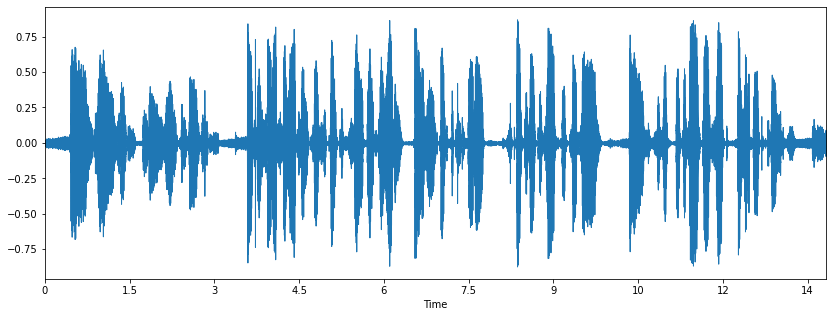

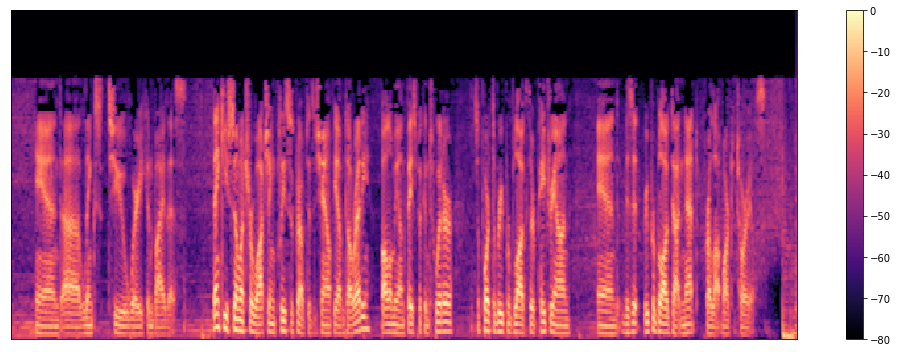

In [54]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

x, sr = librosa.load(path1)

plt.figure(figsize=(14, 5))



librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
#librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
Xdb.shape

S = librosa.feature.melspectrogram(x, sr=16000, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
MFCC = librosa.feature.mfcc(S=log_S, n_mfcc=23)
delta2_mfcc = librosa.feature.delta(MFCC, order=2)

#MFCC = librosa.feature.mfcc(y=x, sr=sample_rate,n_mfcc=23,dct_type=2)
librosa.display.specshow(log_S)
#print(np.max(MFCC),np.min(MFCC))
#MFCC = (MFCC+200)/500
#print(np.max(MFCC),np.min(MFCC))
plt.colorbar()
plt.tight_layout()


/root/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


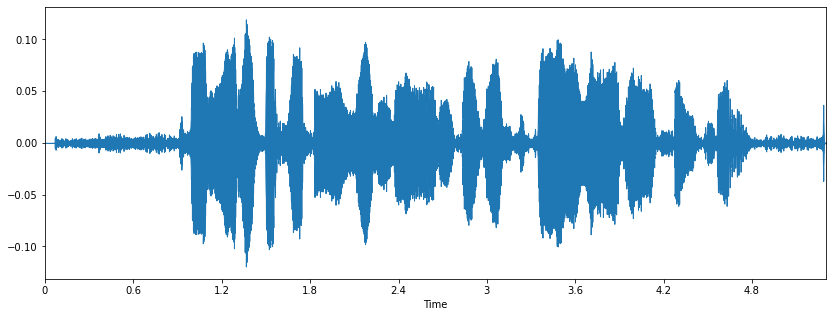

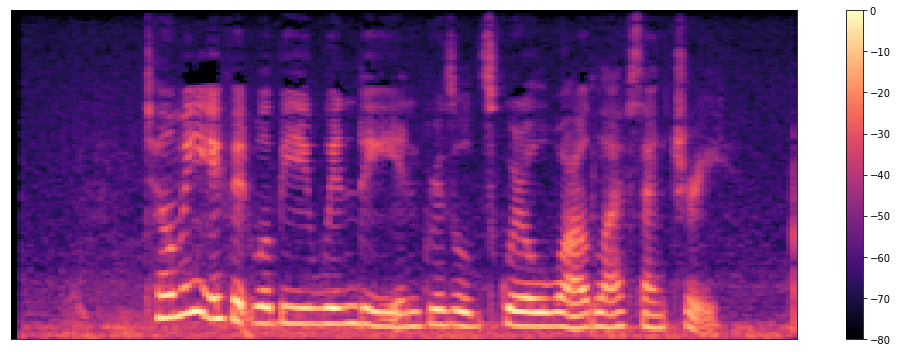

In [55]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

x, sr = librosa.load(path2)

plt.figure(figsize=(14, 5))



librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
#librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
Xdb.shape

S = librosa.feature.melspectrogram(x, sr=16000, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)
MFCC = librosa.feature.mfcc(S=log_S, n_mfcc=23)
delta2_mfcc = librosa.feature.delta(MFCC, order=2)

#MFCC = librosa.feature.mfcc(y=x, sr=sample_rate,n_mfcc=23,dct_type=2)
librosa.display.specshow(log_S)
#print(np.max(MFCC),np.min(MFCC))
#MFCC = (MFCC+200)/500
#print(np.max(MFCC),np.min(MFCC))
plt.colorbar()
plt.tight_layout()


In [28]:
for i in train_ds:
    print(i)
    break

{'spec': tensor([[[-100.0000, -100.0000, -100.0000,  ...,    0.0000,    0.0000,
             0.0000],
         [ -17.4004,  -19.9495,  -25.7240,  ...,    0.0000,    0.0000,
             0.0000],
         [ -10.0892,  -12.6382,  -18.4128,  ...,    0.0000,    0.0000,
             0.0000],
         ...,
         [ -50.2030,  -41.7790,  -45.1695,  ...,    0.0000,    0.0000,
             0.0000],
         [ -49.3981,  -43.7622,  -50.3784,  ...,    0.0000,    0.0000,
             0.0000],
         [ -42.7522,  -46.2232,  -47.1818,  ...,    0.0000,    0.0000,
             0.0000]]]), 'target': 1}


In [56]:
batch_size = 32
num_workers = 20
loaders = {
    "train": DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    ),
    "valid": DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    ),
    "test":DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    ),
}

In [33]:
for i in loaders["train"]:
    print(i)
    break

{'spec': tensor([[[[-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -81.0406,  -86.9085,  -88.0320,  ...,  -33.0473,  -33.0779,
            -34.4528],
          [ -73.7293,  -79.5972,  -80.7207,  ...,  -25.7360,  -25.7666,
            -27.1415],
          ...,
          [ -83.7142, -100.0000, -100.0000,  ...,  -98.3988, -100.0000,
           -100.0000],
          [ -83.7406, -100.0000, -100.0000,  ...,  -94.6323,  -98.8661,
            -95.4140],
          [ -83.7520, -100.0000, -100.0000,  ...,  -96.3413,  -96.9576,
            -98.6038]]],


        [[[-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
           -100.0000],
          [ -64.2927,  -72.7769,  -73.1222,  ...,  -34.8439,  -41.8034,
            -31.7260],
          [ -56.9815,  -65.4656,  -65.8110,  ...,  -27.5326,  -34.4921,
            -24.4148],
          ...,
          [ -98.7733, -100.0000, -100.0000,  ...,  -90.9010, -100.0000,
           -100.0000],
       

In [66]:
import torch.nn as nn

class Predictor(nn.Module):
    def __init__(self, x):
        super(Predictor, self).__init__()
        self.fc2 = nn.Linear(x, 256)
        self.bn2_fc = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 4)
        self.bn_fc3 = nn.BatchNorm1d(4)
    def forward(self, x, reverse=False):
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = F.dropout(x, training=self.training)
        x = F.softmax(self.fc3(x))
        return x

In [67]:
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, 

In [68]:
from torchvision import  models
import torch.optim as optim
from torch.optim import lr_scheduler
model = models.resnet34(pretrained=True)
model.conv1=nn.Conv2d(1, model.conv1.out_channels, 
                      kernel_size=model.conv1.kernel_size[0], 
                      stride=model.conv1.stride[0], 
                      padding=model.conv1.padding[0])
num_ftrs = model.fc.in_features
clf1 = Predictor(num_ftrs)
clf2 = Predictor(num_ftrs)
#model.fc = nn.Linear(num_ftrs, 4)

In [97]:
import numpy as np
np_rng = np.random.default_rng(1)


import urllib.parse
from IPython.display import display, Markdown

import os

from lidbox.meta import (
    common_voice,
    generate_label2target,
    verify_integrity,
    read_audio_durations,
    random_oversampling_on_split
)


test = pd.read_csv("/tf/datasets/new_dev.tsv", sep="\t")

test["path"] = test["path"].apply(lambda x: x[:-3] + "mp3")

test["split"] = "dev"
meta = pd.concat([test])


In [98]:
meta.loc[((meta["locale"] != "kz") & ~(((meta["split"] == "dev") | (meta["split"] == "test")) & ((meta["locale"] == "ru") | (meta["locale"] == "kz") | (meta["locale"] == "en")))), "path"] = "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/" + meta.loc[((meta["locale"] != "kz") & ~(((meta["split"] == "dev") | (meta["split"] == "test")) & ((meta["locale"] == "ru") | (meta["locale"] == "kz") | (meta["locale"] == "en"))))]["locale"]  + "/clips/" + meta.loc[((meta["locale"] != "kz") & ~(((meta["split"] == "dev") | (meta["split"] == "test")) & ((meta["locale"] == "ru") | (meta["locale"] == "kz") | (meta["locale"] == "en"))))]["path"]
targets = {"kz": 0, "ru": 1, "en":2, "other":3}
meta["target"] = meta["locale"]
meta.loc[(meta["locale"] != "kz") & (meta["locale"] != "ru") & (meta["locale"]!="en"), "target"] = "other"
meta = meta.loc[meta["path"] != "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/kz/clips/5f590a130a73c.mp3"]
meta = meta.loc[meta["path"] != "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/kz/clips/5ef9bd9ba7029.mp3"]

meta["id"] = meta["Unnamed: 0"].apply(str)
meta["target"] = meta["target"].map(targets)


workdir = "/tf/datasets/transformer"


In [99]:
meta.loc[meta["split"]=="dev", "Unnamed: 0"] = meta.loc[meta["split"]=="dev"]["path"]

In [100]:
meta["id"] = meta["Unnamed: 0"].apply(str)

In [101]:
meta.loc[meta["split"] == "dev", "id"] = meta.loc[meta["split"] == "dev"]["path"]

In [102]:
meta = meta.set_index("Unnamed: 0")
meta.loc[meta["split"]=="dev"]

,path,locale,split,target,id
Unnamed: 0,,,,,
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/ta/clips/common_voice_ta_19093662.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,ta,dev,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/es/clips/common_voice_es_20252168.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,es,dev,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/it/clips/common_voice_it_23740290.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,it,dev,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/pl/clips/common_voice_pl_22062475.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,pl,dev,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/fr/clips/common_voice_fr_23921769.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,fr,dev,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
...,...,...,...,...,...
BH8c4SbgXss__U__S251---1604.030-1609.420.mp3,BH8c4SbgXss__U__S251---1604.030-1609.420.mp3,ru,dev,1,BH8c4SbgXss__U__S251---1604.030-1609.420.mp3
--RxvUW3u7M__U__S0---0552.770-0565.180.mp3,--RxvUW3u7M__U__S0---0552.770-0565.180.mp3,ru,dev,1,--RxvUW3u7M__U__S0---0552.770-0565.180.mp3
kZ8LKE26cl0__U__S1---0100.470-0114.760.mp3,kZ8LKE26cl0__U__S1---0100.470-0114.760.mp3,ru,dev,1,kZ8LKE26cl0__U__S1---0100.470-0114.760.mp3


In [104]:
loaders["new_test"] = DataLoader(
        meta,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )
DEVICE = 'cuda'


In [109]:
for i in loaders['train']:
    print(i)
    break

In [35]:
from tqdm import tqdm

def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val, max_stable=5):
    best_val_loss = 1e9
    counter = 0
    for epoch in range(epochs):
        #tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))
        
        avg_loss = 0
        model.train()  # train mode
        for batch in tqdm(data_tr):
            loss = 0
            # data to device
            X_batch, Y_batch = batch["spec"], batch["target"]
            #print(X_batch.shape)
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            #print(Y_pred)
            loss = loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights
            if not scheduler is None:
                scheduler.step()
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
      #  toc = time()
        print('loss: %f' % avg_loss)
        # show intermediate results
        model.eval()  # testing mode
        val_loss = 0
        print("start validation")
        for v_b in tqdm(data_val):
            X_val, Y_val = v_b["spec"], v_b["target"]
            Y_hat = model(X_val.to(DEVICE)).detach().cpu()# detach and put into cpu
            val_loss += loss_fn(Y_hat, Y_val)
        val_loss /= len(data_val)
        print( f"validation loss: {val_loss}")
        if val_loss <= best_val_loss and val_loss > 0:
            counter = 0
            print("Save new model!")
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model.h5')
            best_patn = f'{epoch}_{best_val_loss}.h5'
        else:
            counter += 1
        if counter == max_stable:
            break

In [ ]:
DEVICE = 'cuda'
max_epochs = 100
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_model.h5"))
#torch.cuda.empty_cache()
loss_fn =  nn.CrossEntropyLoss()
optimaizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimaizer, T_0=5, T_mult=1, eta_min=1e-8, last_epoch=-1)
train(model, optimaizer,scheduler, loss_fn, max_epochs, loaders["train"], loaders["valid"])

  0%|          | 0/2576 [00:00<?, ?it/s]

* Epoch 1/100


  0%|          | 0/961 [00:00<?, ?it/s]

loss: 0.688309
start validation


100%|██████████| 961/961 [17:54<00:00,  1.12s/it]


validation loss: 0.5830404162406921
Save new model!


  0%|          | 0/2576 [00:00<?, ?it/s]

* Epoch 2/100


In [17]:
model.load_state_dict(torch.load("best_model.h5"))

<All keys matched successfully>

In [186]:
true_labels = []
predicted_labels = []
for batch in loaders["test"]:
    model.eval()
    prediction = model(batch["spec"].to(DEVICE)).detach().cpu()
    predicted_labels.extend(torch.argmax(prediction, dim=1).tolist())
    true_labels.extend(batch["target"].tolist())


In [188]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=list(targets.keys()), labels=range(4))
print(report)



              precision    recall  f1-score   support

          kz       1.00      1.00      1.00     17337
          ru       0.79      0.88      0.83     10374
          en       0.82      0.87      0.85     12956
       other       0.84      0.73      0.78     15077

    accuracy                           0.87     55744
   macro avg       0.86      0.87      0.86     55744
weighted avg       0.88      0.87      0.87     55744



## Testing on VOX

In [22]:
import numpy as np
np_rng = np.random.default_rng(1)


import urllib.parse
from IPython.display import display, Markdown

import os

from lidbox.meta import (
    common_voice,
    generate_label2target,
    verify_integrity,
    read_audio_durations,
    random_oversampling_on_split
)


test = pd.read_csv("/tf/datasets/new_test.tsv", sep="\t")

test["path"] = test["path"].apply(lambda x: x[:-3] + "mp3")

test["split"] = "test"
meta = pd.concat([train, test, dev])


In [23]:
meta.loc[((meta["locale"] != "kz") & ~(((meta["split"] == "dev") | (meta["split"] == "test")) & ((meta["locale"] == "ru") | (meta["locale"] == "kz") | (meta["locale"] == "en")))), "path"] = "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/" + meta.loc[((meta["locale"] != "kz") & ~(((meta["split"] == "dev") | (meta["split"] == "test")) & ((meta["locale"] == "ru") | (meta["locale"] == "kz") | (meta["locale"] == "en"))))]["locale"]  + "/clips/" + meta.loc[((meta["locale"] != "kz") & ~(((meta["split"] == "dev") | (meta["split"] == "test")) & ((meta["locale"] == "ru") | (meta["locale"] == "kz") | (meta["locale"] == "en"))))]["path"]
targets = {"kz": 0, "ru": 1, "en":2, "other":3}
meta["target"] = meta["locale"]
meta.loc[(meta["locale"] != "kz") & (meta["locale"] != "ru") & (meta["locale"]!="en"), "target"] = "other"
meta = meta.loc[meta["path"] != "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/kz/clips/5f590a130a73c.mp3"]
meta = meta.loc[meta["path"] != "/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/kz/clips/5ef9bd9ba7029.mp3"]

meta["id"] = meta["Unnamed: 0"].apply(str)
meta["target"] = meta["target"].map(targets)


workdir = "/tf/datasets/transformer"


In [24]:
meta.loc[(meta["split"] == "test") & (meta["locale"] == "ru"), "path"] = meta.loc[(meta["split"] == "test") & (meta["locale"] == "ru")]["path"].apply(lambda x: f"/tf/datasets/vox/ru_test/{x}")
meta.loc[(meta["split"] == "test") & (meta["locale"] == "ru"), "path"]
meta.loc[(meta["split"] == "test") & (meta["locale"] == "kz"), "path"] = meta.loc[(meta["split"] == "test") & (meta["locale"] == "kz")]["path"].apply(lambda x: f"/tf/datasets/vox/kz_test/{x}")
meta.loc[(meta["split"] == "test") & (meta["locale"] == "kz"), "path"] 
meta.loc[(meta["split"] == "test") & (meta["locale"] == "en"), "path"] = meta.loc[(meta["split"] == "test") & (meta["locale"] == "en")]["path"].apply(lambda x: f"/tf/datasets/vox/en_test/{x}")
meta.loc[(meta["split"] == "test") & (meta["locale"] == "en"), "path"] 

0       /tf/datasets/vox/en_test/shrDRhToGpY__U__S133-...
1       /tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123-...
2       /tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---...
3       /tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---...
4       /tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---...
                              ...                        
9995    /tf/datasets/vox/en_test/KLiy94kfZI4__U__S133-...
9996    /tf/datasets/vox/en_test/YTlliEr5LOA__U__S113-...
9997    /tf/datasets/vox/en_test/bSs0gNq6Kkc__U__S0---...
9998    /tf/datasets/vox/en_test/Da7c-BY6MDA__U__S2---...
9999    /tf/datasets/vox/en_test/VWvPndMo1F8__U__S24--...
Name: path, Length: 10000, dtype: object

In [25]:
meta.loc[meta["split"]=="test", "Unnamed: 0"] = meta.loc[meta["split"]=="test"]["path"]

In [26]:
meta["id"] = meta["Unnamed: 0"].apply(str)

In [27]:
meta.loc[meta["split"] == "test", "id"] = meta.loc[meta["split"] == "test"]["path"]

In [28]:
meta = meta.set_index("Unnamed: 0")
meta.loc[meta["split"]=="test"]

,path,locale,split,target,id
Unnamed: 0,,,,,
/tf/datasets/vox/en_test/shrDRhToGpY__U__S133---0944.430-0958.260.mp3,/tf/datasets/vox/en_test/shrDRhToGpY__U__S133-...,en,test,2,/tf/datasets/vox/en_test/shrDRhToGpY__U__S133-...
/tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123---0427.020-0444.670.mp3,/tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123-...,en,test,2,/tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123-...
/tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---0398.760-0403.940.mp3,/tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---...,en,test,2,/tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---...
/tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---1473.480-1485.720.mp3,/tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---...,en,test,2,/tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---...
/tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---0125.230-0140.900.mp3,/tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---...,en,test,2,/tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---...
...,...,...,...,...,...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/it/clips/common_voice_it_20015623.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,it,test,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/uk/clips/common_voice_uk_23554602.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,uk,test,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...
/tf/datasets/data_untar/cv-corpus-6.1-2020-12-11/tr/clips/common_voice_tr_20416266.mp3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...,tr,test,3,/tf/datasets/data_untar/cv-corpus-6.1-2020-12-...


In [25]:
meta.loc[meta["split"] == "test"] = meta.loc[(meta["split"] == "test") & (meta["target"] != 3)] 

In [26]:
meta.loc[meta["split"]=="test", "id"] = meta.loc[meta["split"]=="test"]["path"]
meta.loc[meta["split"]=="test"] 

,path,locale,split,target,id
Unnamed: 0,,,,,
/tf/datasets/vox/en_test/shrDRhToGpY__U__S133---0944.430-0958.260.mp3,/tf/datasets/vox/en_test/shrDRhToGpY__U__S133-...,en,test,2.0,/tf/datasets/vox/en_test/shrDRhToGpY__U__S133-...
/tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123---0427.020-0444.670.mp3,/tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123-...,en,test,2.0,/tf/datasets/vox/en_test/mzfg0RGJnV8__U__S123-...
/tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---0398.760-0403.940.mp3,/tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---...,en,test,2.0,/tf/datasets/vox/en_test/-_PPCH3y0eE__U__S1---...
/tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---1473.480-1485.720.mp3,/tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---...,en,test,2.0,/tf/datasets/vox/en_test/DQMxvGYyu6Q__U__S0---...
/tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---0125.230-0140.900.mp3,/tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---...,en,test,2.0,/tf/datasets/vox/en_test/x4lfSc7PrB0__U__S0---...
...,...,...,...,...,...
/tf/datasets/vox/kz_test/rCpb0p_lyxI__U__S25---0107.830-0127.780.mp3,/tf/datasets/vox/kz_test/rCpb0p_lyxI__U__S25--...,kz,test,0.0,/tf/datasets/vox/kz_test/rCpb0p_lyxI__U__S25--...
/tf/datasets/vox/kz_test/BkLVX9wf2YI__U__S26---0236.830-0241.550.mp3,/tf/datasets/vox/kz_test/BkLVX9wf2YI__U__S26--...,kz,test,0.0,/tf/datasets/vox/kz_test/BkLVX9wf2YI__U__S26--...
/tf/datasets/vox/kz_test/RqdH-JD8TpM__U__S78---0466.720-0470.860.mp3,/tf/datasets/vox/kz_test/RqdH-JD8TpM__U__S78--...,kz,test,0.0,/tf/datasets/vox/kz_test/RqdH-JD8TpM__U__S78--...


In [27]:
newtest_ds = AudiosDataset(meta.loc[meta["split"]=="test"]["path"], meta.loc[meta["split"]=="test"]["target"])

In [38]:
loaders["new_test"] = DataLoader(
        newtest_ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )
DEVICE = 'cuda'
model = model.to(DEVICE)

In [39]:
true_labels = []
predicted_labels = []
for batch in loaders["new_test"]:
    model.eval()
    prediction = model(batch["spec"].to(DEVICE)).detach().cpu()
    predicted_labels.extend(torch.argmax(prediction, dim=1).tolist())
    true_labels.extend(batch["target"].tolist())


In [40]:
from sklearn.metrics import classification_report

report = classification_report(true_labels, predicted_labels, target_names=list(targets.keys()), labels=range(4))
print(report)



              precision    recall  f1-score   support

          kz       0.35      0.67      0.46     13925
          ru       0.33      0.01      0.02     12107
          en       0.26      0.12      0.17     10000
       other       0.00      0.00      0.00         0

    accuracy                           0.30     36032
   macro avg       0.23      0.20      0.16     36032
weighted avg       0.32      0.30      0.23     36032



/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
